In [1]:
import pandas as pd

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np


# Import data from Liana

In [4]:
core=pd.read_csv('../../Downloads/cpdb_res_core.csv').sort_values('cellphone_pvals')
core=core[(core['source']=='Tumor C') & (core['cellphone_pvals']<0.01)]

peri=pd.read_csv('../../Downloads/cpdb_res_peri.csv').sort_values('cellphone_pvals')
peri=peri[(peri['source']=='Tumor P') & (peri['cellphone_pvals']<0.01)]

In [5]:
#additional filtration of low-quality pairs (if needed)
# core=core[ (core['cellphone_pvals']<0.01) & (core['lr_means']>0.5) & (core['receptor_means']>0.5)& (core['ligand_means']>0.5)& (core['ligand_props']>0.3) & (core['receptor_props']>0.3)]
# peri=peri[  (peri['cellphone_pvals']<0.01) & (peri['lr_means']>0.5) & (peri['receptor_means']>0.5)& (peri['ligand_means']>0.5)& (peri['ligand_props']>0.5) & (peri['receptor_props']>0.5)]

In [5]:
core['target'].value_counts()

target
Tumor C             264
Neurons             205
Microglial cells    140
Astrocytes          100
Oligodendrocytes     82
OPCs                 77
T cells              51
Name: count, dtype: int64

In [6]:
peri['target'].value_counts()

target
Astrocytes          491
Neurons             400
OPCs                321
Tumor P             292
Microglial cells    220
Oligodendrocytes    166
T cells             155
Name: count, dtype: int64

In [7]:
core["Li_Rs"] = core["ligand"] + "_" + core["receptor"]
peri["Li_Rs"] = peri["ligand"] + "_" + peri["receptor"]


# Tumor is a source , other cell types are target

In [8]:
core = core.copy()
peri = peri.copy()

core["target"] = core["target"].replace({"Tumor C": "Tumor"})
peri["target"] = peri["target"].replace({"Tumor P": "Tumor"})


In [9]:
cols = ["target", "Li_Rs", "lr_means"]

core_small = core[cols].rename(columns={"lr_means": "lr_core"})
peri_small = peri[cols].rename(columns={"lr_means": "lr_peri"})
peri_small

,target,Li_Rs,lr_peri
11093,Microglial cells,RARRES2_CMKLR1,0.361658
11098,Neurons,COL6A1_ITGB8,0.361561
11067,Neurons,AGRN_ATP1A3,0.362528
11031,T cells,BMP7_ACTR2,0.363696
11032,Microglial cells,C3_ITGAM,0.363614
...,...,...,...
14824,Astrocytes,NECTIN3_NECTIN1,0.255430
3632,T cells,CALM1_PTPRA,0.776795
17091,Astrocytes,SEMA4B_DCBLD2,0.204555
16668,Astrocytes,COL4A1_ITGA9,0.213284


In [10]:
# compute number of interactions in each group
core_counts = core_small['target'].value_counts().reset_index()
core_counts.columns = ['target', 'count']
core_counts['interaction_type'] = 'Core'
peri_counts = peri_small['target'].value_counts().reset_index()
peri_counts.columns = ['target', 'count']
peri_counts['interaction_type'] = 'Perimarginal'
counts_combined = pd.concat([core_counts, peri_counts], ignore_index=True)

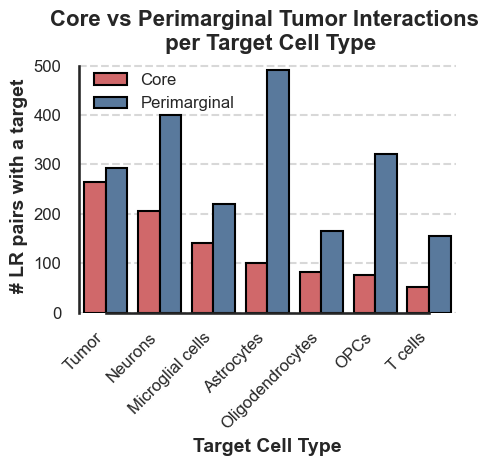

In [11]:
sns.set_style("white")  
sns.set_context("talk")  

palette = {
    "Core": "#E15759",        
    "Perimarginal": "#4E79A7" 
}

plt.figure(figsize=(5, 5))

barplot = sns.barplot(
    data=counts_combined,
    x='target',
    y='count',
    hue='interaction_type',
    palette=palette,
    edgecolor='black',   
    linewidth=1.5
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Target Cell Type', fontsize=14, fontweight='bold')
plt.ylabel('# LR pairs with a target', fontsize=14, fontweight='bold')
plt.title('Core vs Perimarginal Tumor Interactions \n per Target Cell Type', fontsize=16, fontweight='bold')

sns.despine(trim=True)
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.3)
plt.legend(title='', fontsize=12, title_fontsize=10, frameon=False,loc='upper left' )
plt.tight_layout()
plt.show()


In [12]:
df = pd.merge(core_small, peri_small, on=["target", "Li_Rs"], how="outer")
df["lr_core"] = df["lr_core"].fillna(0)
df["lr_peri"] = df["lr_peri"].fillna(0)
df["diff"] = df["lr_core"] - df["lr_peri"]
df["abs_diff"] = df["diff"].abs()

In [16]:
celltypes = df["target"].unique().tolist()
celltypes_filtered=['Tumor', 'Astrocytes',
 'Neurons',
# 'T cells',
 'Microglial cells',
 'OPCs',
 'Oligodendrocytes'] # for the order, also T cells are strange, I remove them (probably not enough cells?)

In [17]:
top20_dict = {}
for ct in celltypes:
    sub = df[df["target"] == ct].copy()
    top20 = sub.sort_values("abs_diff", ascending=False).head(20)
    top20_dict[ct] = top20

/var/folders/mk/9hzfb0wd5w1fctlgjfv6lqx80000gp/T/ipykernel_46788/639709421.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


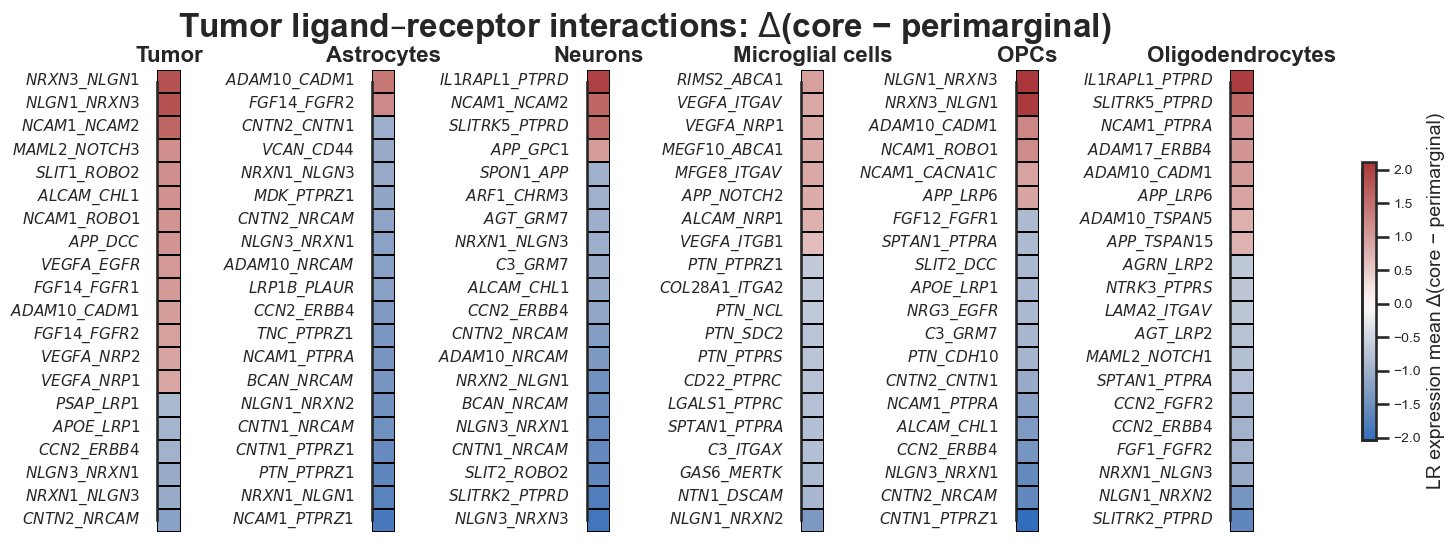

In [18]:
sns.set_style("white")   # clean white background
sns.set_context("talk")  # larger fonts
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 10,
})

all_diffs = df.loc[df["target"].isin(celltypes_filtered), "diff"].values
vmin = np.nanmin(all_diffs)
vmax = np.nanmax(all_diffs)

fig, axes = plt.subplots(
    1, len(celltypes_filtered),
    figsize=(3 * len(celltypes_filtered), 6),  
    squeeze=False,
    gridspec_kw={'wspace': 0.02}  
)

mappable = None
for ax, ct in zip(axes[0], celltypes_filtered):
    data = top20_dict[ct].copy()
    data = data.sort_values("diff", ascending=False)
    heat = data.pivot(index="Li_Rs", columns="target", values="diff")
    heat.index = [r"$\it{" + x.replace("_", r"\_") + "}$" for x in heat.index]
    hm = sns.heatmap(
        heat.sort_values(ct, ascending=False),
        cmap="vlag",
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar=False,
        linewidths=1.2,         
        linecolor="black",
        square=True
    )
    if mappable is None:
        mappable = hm.get_children()[0]
    ax.set_title(ct, fontsize=16, fontweight="bold")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="y", labelsize=11)
    ax.set_xticklabels([])

fig.suptitle(
    r"Tumor ligand–receptor interactions: $\Delta$(core − perimarginal)",
    fontsize=24,
    fontweight="bold"
)

cbar = fig.colorbar(
    mappable,
    ax=axes,
    anchor=(1.2, 0.5), 
    shrink=0.6,
    fraction=0.05,
    pad=0.03
)
cbar.set_label("LR expression mean Δ(core − perimarginal)", fontsize=14)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

# Tumor is a target, other cells as a source

In [19]:
core=pd.read_csv('../../Downloads/cpdb_res_core.csv').sort_values('cellphone_pvals')
core=core[(core['target']=='Tumor C') & (core['cellphone_pvals']<0.05)]

peri=pd.read_csv('../../Downloads/cpdb_res_peri.csv').sort_values('cellphone_pvals')
peri=peri[(peri['target']=='Tumor P') & (peri['cellphone_pvals']<0.05)]

In [20]:
# filtration
# core=core[ (core['cellphone_pvals']<0.01) & (core['lr_means']>0.5) & (core['receptor_means']>0.5)& (core['ligand_means']>0.5)& (core['ligand_props']>0.3) & (core['receptor_props']>0.3)]
# peri=peri[  (peri['cellphone_pvals']<0.01) & (peri['lr_means']>0.5) & (peri['receptor_means']>0.5)& (peri['ligand_means']>0.5)& (peri['ligand_props']>0.5) & (peri['receptor_props']>0.5)]

In [21]:
core['source'].value_counts()

source
Tumor C             270
Neurons             204
OPCs                132
Oligodendrocytes    122
Astrocytes          121
Microglial cells    104
T cells              22
Name: count, dtype: int64

In [22]:
peri['source'].value_counts()

source
Astrocytes          424
Neurons             324
Tumor P             302
OPCs                282
Microglial cells    148
Oligodendrocytes    122
T cells              72
Name: count, dtype: int64

In [23]:
core["Li_Rs"] = core["ligand"] + "_" + core["receptor"]
peri["Li_Rs"] = peri["ligand"] + "_" + peri["receptor"]


In [24]:
# Make copies if needed
core = core.copy()
peri = peri.copy()

# Harmonize tumor names
core["target"] = core["target"].replace({"Tumor C": "Tumor"})
peri["target"] = peri["target"].replace({"Tumor P": "Tumor"})
core["source"] = core["source"].replace({"Tumor C": "Tumor"})
peri["source"] = peri["source"].replace({"Tumor P": "Tumor"})


In [25]:
peri

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals,Li_Rs
11082,COL9A2,COL9A2,0.329638,0.254416,CD44,CD44,0.394620,0.249097,Oligodendrocytes,Tumor,0.362129,0.000,COL9A2_CD44
11089,LRRC4B,LRRC4B,0.335952,0.582305,PTPRF,PTPRF,0.387757,0.290614,Neurons,Tumor,0.361855,0.000,LRRC4B_PTPRF
11107,CSPG4,CSPG4,0.488195,0.471304,ITGA3,ITGA3_ITGB1,0.233958,0.175090,OPCs,Tumor,0.361077,0.000,CSPG4_ITGA3
11041,ADAM12,ADAM12,0.482138,0.593625,ITGB1,ITGB1,0.244422,0.196751,Astrocytes,Tumor,0.363280,0.000,ADAM12_ITGB1
11052,DLL1,DLL1,0.317199,0.207581,NOTCH2,NOTCH2,0.408851,0.285199,Tumor,Tumor,0.363025,0.000,DLL1_NOTCH2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,SEMA4D,SEMA4D,0.643682,0.412974,PLXNB1,PLXNB1,0.663105,0.422383,Microglial cells,Tumor,0.653393,0.044,SEMA4D_PLXNB1
4979,MEGF10,MEGF10,0.487774,0.285714,ABCA1,ABCA1,0.811987,0.444043,T cells,Tumor,0.649880,0.044,MEGF10_ABCA1
16615,PROS1,PROS1,0.250364,0.203971,TYRO3,TYRO3,0.179084,0.158845,Tumor,Tumor,0.214724,0.045,PROS1_TYRO3
742,NRXN1,NRXN1,0.495967,0.300320,NLGN1,NLGN1,2.587842,0.832130,Microglial cells,Tumor,1.541904,0.046,NRXN1_NLGN1


In [26]:
cols = ["source", "Li_Rs", "lr_means"]

core_small = core[cols].rename(columns={"lr_means": "lr_core"})
peri_small = peri[cols].rename(columns={"lr_means": "lr_peri"})
peri_small

,source,Li_Rs,lr_peri
11082,Oligodendrocytes,COL9A2_CD44,0.362129
11089,Neurons,LRRC4B_PTPRF,0.361855
11107,OPCs,CSPG4_ITGA3,0.361077
11041,Astrocytes,ADAM12_ITGB1,0.363280
11052,Tumor,DLL1_NOTCH2,0.363025
...,...,...,...
4935,Microglial cells,SEMA4D_PLXNB1,0.653393
4979,T cells,MEGF10_ABCA1,0.649880
16615,Tumor,PROS1_TYRO3,0.214724
742,Microglial cells,NRXN1_NLGN1,1.541904


In [27]:
core_counts = core_small['source'].value_counts().reset_index()
core_counts.columns = ['source', 'count']
core_counts['interaction_type'] = 'Core'
peri_counts = peri_small['source'].value_counts().reset_index()
peri_counts.columns = ['source', 'count']
peri_counts['interaction_type'] = 'Perimarginal'
counts_combined = pd.concat([core_counts, peri_counts], ignore_index=True)

In [28]:
counts_combined=counts_combined[counts_combined['source']!='Tumor']

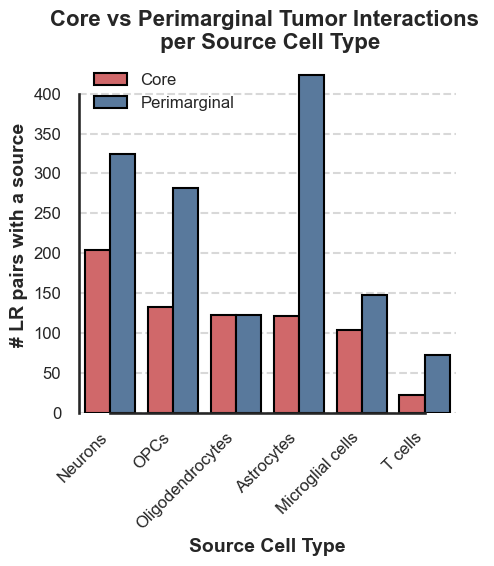

In [29]:
sns.set_style("white")  
sns.set_context("talk")  

palette = {
    "Core": "#E15759",        
    "Perimarginal": "#4E79A7" 
}

plt.figure(figsize=(5, 6))

barplot = sns.barplot(
    data=counts_combined,
    x='source',
    y='count',
    hue='interaction_type',
    palette=palette,
    edgecolor='black',   
    linewidth=1.5
)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Source Cell Type', fontsize=14, fontweight='bold')
plt.ylabel('# LR pairs with a source', fontsize=14, fontweight='bold')
plt.title('Core vs Perimarginal Tumor Interactions \n per Source Cell Type', fontsize=16, fontweight='bold')

sns.despine(trim=True)
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.3)
plt.legend(title='', fontsize=12, title_fontsize=10, frameon=False,loc='upper left' )
plt.tight_layout()
plt.show()


In [30]:
df = pd.merge(core_small, peri_small, on=["source", "Li_Rs"], how="outer")
df["lr_core"] = df["lr_core"].fillna(0)
df["lr_peri"] = df["lr_peri"].fillna(0)
df["diff"] = df["lr_core"] - df["lr_peri"]
df["abs_diff"] = df["diff"].abs()

In [31]:
celltypes = df["source"].unique().tolist()
celltypes

['Neurons',
 'Oligodendrocytes',
 'Tumor',
 'OPCs',
 'Microglial cells',
 'T cells',
 'Astrocytes']

In [32]:
top20_dict = {}
for ct in celltypes:
    sub = df[df["source"] == ct].copy()
    top20 = sub.sort_values("abs_diff", ascending=False).head(20)
    top20_dict[ct] = top20

In [33]:
celltypes_filtered=['Neurons',
 'Oligodendrocytes',
 'OPCs',
 'Microglial cells',
 'Astrocytes']

/var/folders/mk/9hzfb0wd5w1fctlgjfv6lqx80000gp/T/ipykernel_46788/4005268252.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


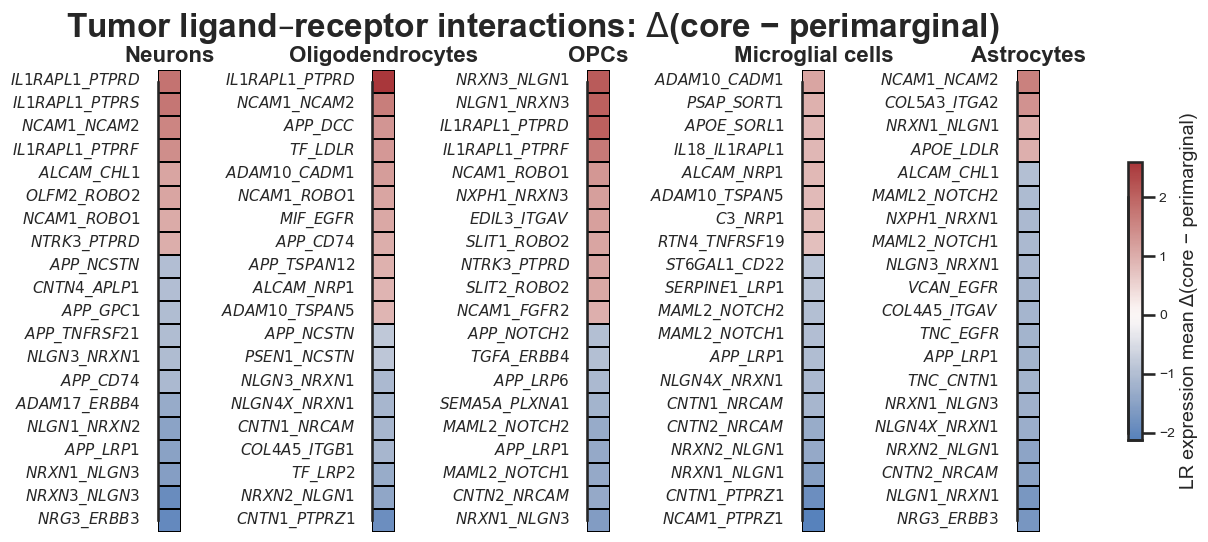

In [34]:
sns.set_style("white")   
sns.set_context("talk")  
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 10,
})

all_diffs = df.loc[df["source"].isin(celltypes_filtered), "diff"].values
vmin = np.nanmin(all_diffs)
vmax = np.nanmax(all_diffs)

fig, axes = plt.subplots(
    1, len(celltypes_filtered),
    figsize=(3 * len(celltypes_filtered), 6),  
    squeeze=False,
    gridspec_kw={'wspace': 0.02}  
)

mappable = None
for ax, ct in zip(axes[0], celltypes_filtered):
    data = top20_dict[ct].copy()
    data = data.sort_values("diff", ascending=False)
    heat = data.pivot(index="Li_Rs", columns="source", values="diff")
    heat.index = [r"$\it{" + x.replace("_", r"\_") + "}$" for x in heat.index]

    hm = sns.heatmap(
        heat.sort_values(ct, ascending=False),
        cmap="vlag",
        center=0,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar=False,
        linewidths=1.2,         
        linecolor="black",
        square=True
    )

    if mappable is None:
        mappable = hm.get_children()[0]

    ax.set_title(ct, fontsize=16, fontweight="bold")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="y", labelsize=11)
    ax.set_xticklabels([])

fig.suptitle(
    r"Tumor ligand–receptor interactions: $\Delta$(core − perimarginal)",
    fontsize=24,
    fontweight="bold"
)

cbar = fig.colorbar(
    mappable,
    ax=axes,
    anchor=(1.2, 0.5), 
    shrink=0.6,
    fraction=0.05,
    pad=0.03
)
cbar.set_label("LR expression mean Δ(core − perimarginal)", fontsize=14)
sns.despine(trim=True)
plt.tight_layout()
plt.show()